In [1]:
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *
from libs.alpha_shape import *

from mplsoccer import Pitch
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch

from matplotlib.patches import Polygon



In [2]:
df = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
df = extract_one_match(df,1)


In [3]:
# Inspect the column names of the DataFrame to find the right player column names
print(df.columns)


Index(['Time [s]', 'Time [s]_team', 'half_team', 'minute_team', 'Period_team',
       'home_6_x', 'home_6_y', 'home_18_x', 'home_18_y', 'home_1_x',
       'home_1_y', 'home_10_x', 'home_10_y', 'home_3_x', 'home_3_y',
       'home_2_x', 'home_2_y', 'home_19_x', 'home_19_y', 'home_21_x',
       'home_21_y', 'home_9_x', 'home_9_y', 'home_17_x', 'home_17_y',
       'home_23_x', 'home_23_y', 'home_20_x', 'home_20_y', 'home_15_x',
       'home_15_y', 'home_8_x', 'home_8_y', 'home_5_x', 'home_5_y',
       'home_12_x', 'home_12_y', 'ball_x_team', 'ball_y_team', 'ball_z_team',
       'half', 'minute', 'Period', 'away_10_x', 'away_10_y', 'away_2_x',
       'away_2_y', 'away_17_x', 'away_17_y', 'away_22_x', 'away_22_y',
       'away_9_x', 'away_9_y', 'away_1_x', 'away_1_y', 'away_20_x',
       'away_20_y', 'away_21_x', 'away_21_y', 'away_11_x', 'away_11_y',
       'away_13_x', 'away_13_y', 'away_6_x', 'away_6_y', 'away_7_x',
       'away_7_y', 'away_5_x', 'away_5_y', 'away_14_x', 'away_14_y',
   

Frame 0: Player Positions: [[ 1.88639832e+01  6.93741989e+00]
 [ 1.61913834e+01  2.77901745e+01]
 [ 5.25321732e+01 -1.65960975e-02]
 [ 8.07766628e+00 -4.84487391e+00]
 [ 1.75366268e+01 -5.47745609e+00]
 [ 1.80319729e+01  1.68252964e+01]
 [ 2.14627862e-01  9.72876167e+00]
 [ 6.49289799e+00  1.42638140e+01]
 [ 3.04487169e-01 -9.10663509e+00]
 [ 1.52157774e+01 -2.19803638e+01]
 [ 9.65033150e+00  6.96267366e+00]]
Frame 1: Player Positions: [[ 1.96943893e+01  8.17001247e+00]
 [ 1.73564873e+01  2.81198959e+01]
 [ 5.15782852e+01  4.15617824e-02]
 [ 5.02495670e+00 -8.37963390e+00]
 [ 1.58267651e+01 -6.29965639e+00]
 [ 1.94854088e+01  1.85229454e+01]
 [-6.24823141e+00  8.15519238e+00]
 [ 5.37473249e+00  1.53239279e+01]
 [-8.01075935e+00 -5.36660004e+00]
 [ 1.37882938e+01 -2.23417931e+01]
 [ 1.10320749e+01  7.93272877e+00]]
Frame 2: Player Positions: [[ 22.92759323   7.91264629]
 [ 22.33288193  28.51857948]
 [ 47.30565643   0.60377926]
 [  5.8833704   -6.06064749]
 [ 17.34656143  -5.25089598]
 [

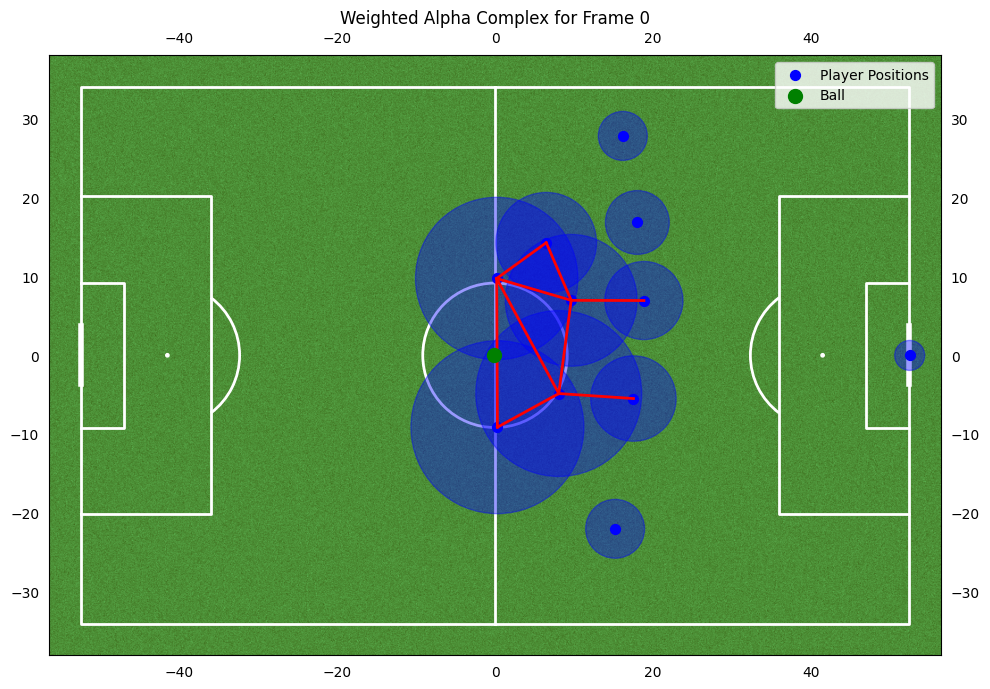

In [10]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from shapely.geometry import Polygon
from matplotlib.patches import Circle

# Step 1: Calculate Weights Based on Ball Proximity
def calculate_weights(df, ball_x_col='ball_x', ball_y_col='ball_y', regex="^home"):
    ball_x = df[ball_x_col].values
    ball_y = df[ball_y_col].values
    player_cols = df.filter(regex=regex).columns
    
    # Extract player positions and calculate inverse distance to the ball
    weights_list = []
    x_cols = [col for col in player_cols if col.endswith('_x')]
    y_cols = [col for col in player_cols if col.endswith('_y')]
    
    for frame_idx in range(len(df)):
        weights = []
        for i in range(len(x_cols)):  # Loop through all players
            player_x = df.loc[frame_idx, x_cols[i]]
            player_y = df.loc[frame_idx, y_cols[i]]
            
            # Check if player_x or player_y is NaN (inactive player)
            if np.isnan(player_x) or np.isnan(player_y):
                continue  # Skip this player if they are inactive
            
            # Calculate the distance to the ball
            distance_to_ball = np.sqrt((player_x - ball_x[frame_idx])**2 + (player_y - ball_y[frame_idx])**2)
            weight = 1 / (distance_to_ball + 1e-6)  # Inverse distance to the ball
            weights.append(weight)
        
        weights_list.append(np.array(weights))
    
    return weights_list  # Return a list of arrays with variable lengths

# Step 2: Weighted Alpha Complex Calculation
def weighted_alpha_complex(df, weights_list, regex="^home", num_players=11, max_alpha_square=0.05):
    """
    Computes a weighted Alpha Complex for player positions, where weights are calculated based on proximity to the ball.
    """
    df_filtered = df.filter(regex=regex)
    np_data = df_filtered.to_numpy()  # Convert DataFrame to NumPy array
    points = []

    # Extract player positions for each frame
    for row in np_data:
        row = row[~np.isnan(row)]  # Remove NaN values (incomplete player positions)
        player_positions = list(zip(row[0::2], row[1::2]))  # Create (x, y) pairs
        
        # Add points and corresponding weights
        points.append(np.array(player_positions))
    
    # Print points used for the alpha complex
    for i, p in enumerate(points):
        print(f"Frame {i}: Player Positions: {p}")
    
    # Compute weighted alpha complexes for each frame
    weighted_alpha_complexes = []
    for frame_idx, data in enumerate(points):
        if len(data) >= 3:  # Alpha complex requires at least 3 points
            # Combine points with weights (ensure we match points with weights)
            if len(data) == len(weights_list[frame_idx]):  # Make sure sizes match
                weighted_points = np.hstack([data, weights_list[frame_idx].reshape(-1, 1)])  # Points + weights
            
                # Compute Alpha Complex with weights
                alpha_complex = gd.AlphaComplex(points=weighted_points)
                simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=max_alpha_square)
                weighted_alpha_complexes.append(simplex_tree)
            else:
                print(f"Frame {frame_idx}: Mismatch between player positions and weights.")
                weighted_alpha_complexes.append(None)  # Add a placeholder if mismatch occurs

    return weighted_alpha_complexes, df.index.to_numpy()


def circles_overlap(player1, player2, radius1, radius2):
    """
    Check if two circles overlap based on their centers and radii.
    """
    distance = np.sqrt((player1[0] - player2[0])**2 + (player1[1] - player2[1])**2)
    return distance <= (radius1 + radius2)

def plot_alpha_complex_with_ball(df, alpha_complexes, frame_idx, weights_list, subsampled_indices, max_alpha_square=0.05):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    fig, ax = football_pitch.draw(figsize=(10, 7))
    
    # Find the correct index in the original DataFrame
    original_frame_idx = subsampled_indices[frame_idx]
    
    # Extract player positions for the given frame
    players = df.iloc[frame_idx].filter(regex="^home").dropna().values.reshape(-1, 2)
    
    # Extract ball position for the given frame using the original index
    ball_x = df.loc[original_frame_idx, 'ball_x']
    ball_y = df.loc[original_frame_idx, 'ball_y']
    
    # Scatter player points
    ax.scatter(players[:, 0], players[:, 1], color='blue', s=50, label="Player Positions")
    
    # Plot the ball position
    ax.scatter(ball_x, ball_y, color='green', s=100, label="Ball", zorder=5)

    # Plot circles around each player point to represent their weights
    weights = weights_list[frame_idx]
    circle_radii = []
    for i, (player, weight) in enumerate(zip(players, weights)):
        circle_radius = weight * 100  # Scale the weight to make the circle size more visible
        circle_radii.append(circle_radius)
        circle = Circle((player[0], player[1]), radius=circle_radius, color='blue', alpha=0.4, fill=True)
        ax.add_patch(circle)

    # Plot the weighted alpha complex boundary based on overlap
    alpha_complex = alpha_complexes[frame_idx]
    if alpha_complex is not None:
        for simplex in alpha_complex.get_skeleton(1):  # 1D simplices (edges)
            if len(simplex[0]) == 2:  # Only consider edges (1D)
                vertex_1, vertex_2 = players[simplex[0][0]], players[simplex[0][1]]
                radius_1, radius_2 = circle_radii[simplex[0][0]], circle_radii[simplex[0][1]]
                # Check if circles overlap before plotting the edge
                if circles_overlap(vertex_1, vertex_2, radius_1, radius_2):
                    ax.plot([vertex_1[0], vertex_2[0]], [vertex_1[1], vertex_2[1]], color='red', lw=2)

    plt.legend()
    plt.title(f"Weighted Alpha Complex for Frame {frame_idx}")
    plt.show()

# Now let's run the pipeline
# Calculate weights based on proximity to the ball for all frames
weights = calculate_weights(df)

# Step 2: Compute the weighted alpha complex for each frame
alpha_complexes, frame_indices = weighted_alpha_complex(df.iloc[::48], weights, regex="^home", num_players=11, max_alpha_square=600)

# Step 3: Plot the weighted alpha complex for a specific frame with circles around players
frame_idx = frame_indices[1]  # Frame in the subsampled data

plot_alpha_complex_with_ball(df.iloc[::48], alpha_complexes, frame_idx, weights, frame_indices)



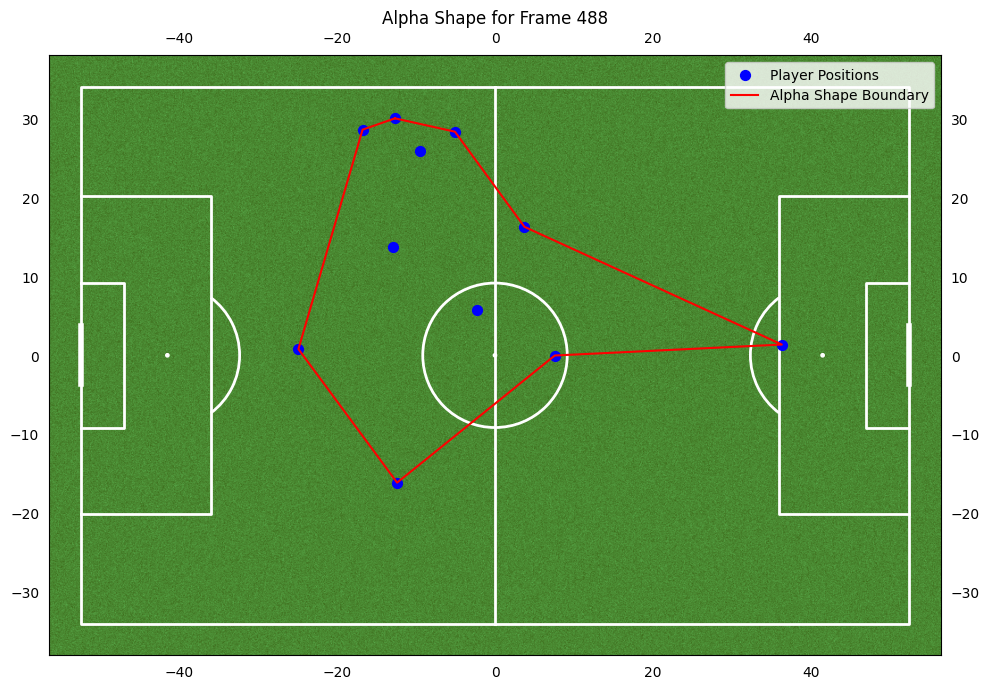

In [3]:
# Now run the alpha shape function with a smaller alpha value
alpha_shapes, frame_indices = alpha_shape(df.iloc[::48], "^home", num_players=11, alpha=0.05)

# Plot the alpha shape for a specific frame
frame_idx = 488

# Create a plot with the pitch
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# Scatter the player points for that frame
players = df.iloc[frame_indices[frame_idx]].filter(regex="^home").dropna().values.reshape(-1, 2)
ax.scatter(players[:, 0], players[:, 1], color='blue', s=50, label="Player Positions")

alpha_shape_polygon = alpha_shapes[frame_idx]

x, y = alpha_shape_polygon.exterior.xy
ax.plot(x, y, color='red', label="Alpha Shape Boundary")


plt.legend()
plt.title(f"Alpha Shape for Frame {frame_idx}")
plt.show()


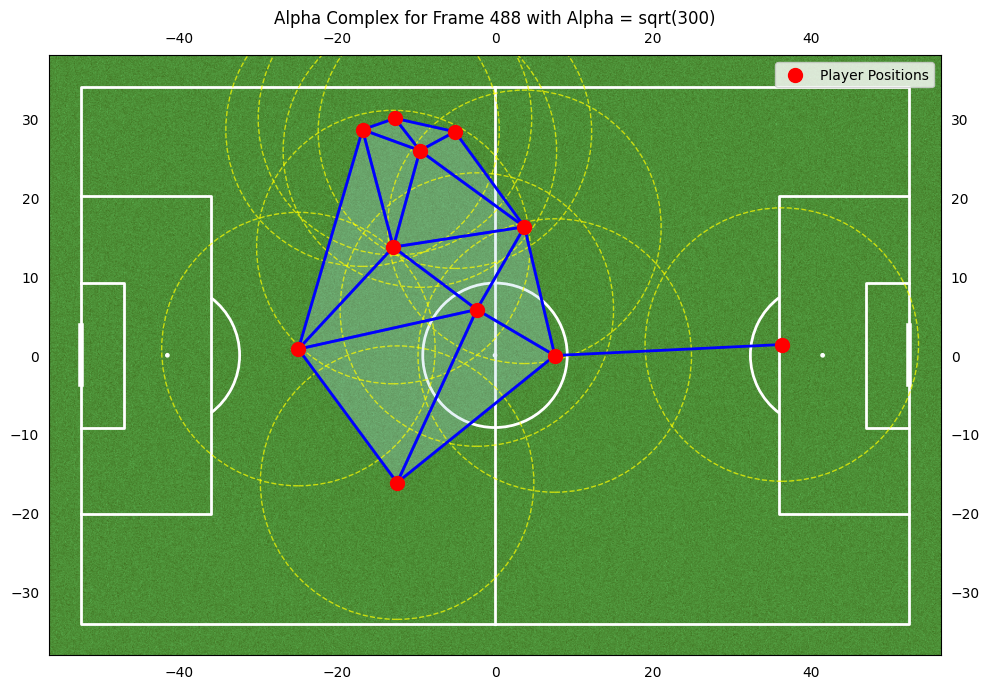

In [19]:

# Apply alpha complex and plot for a specific frame with circles
alpha_complex_on_frame(df[::48], regex="^home", frame_idx=frame_idx, max_alpha_square=300)


Average Wasserstein distance between frame 100 and frame 150: 5.926156463948163


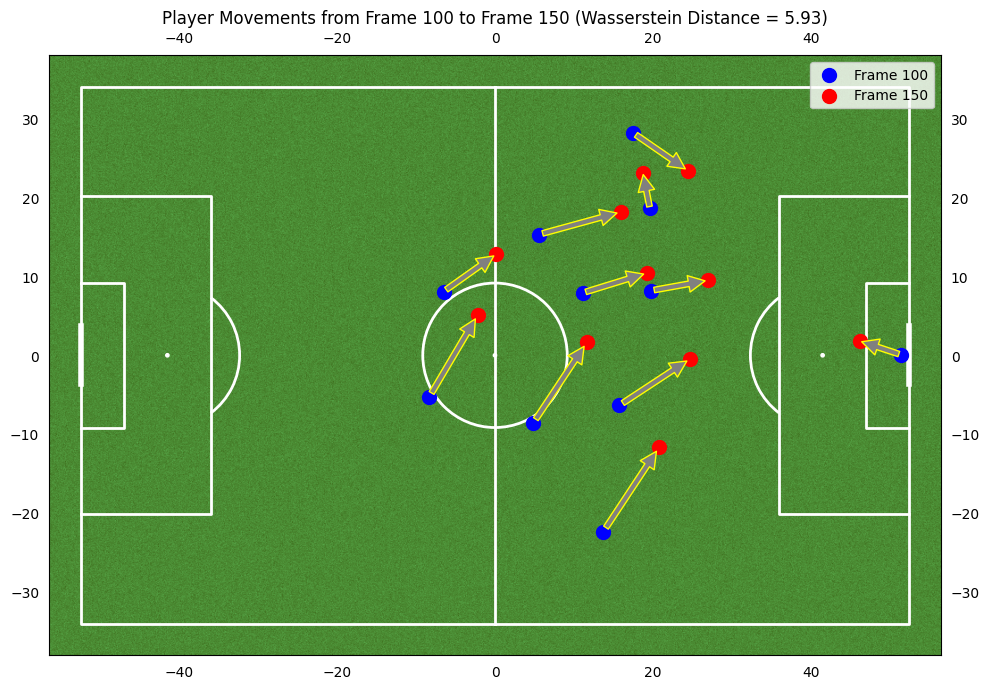

In [15]:
import numpy as np
from scipy.stats import wasserstein_distance
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Example function to get player positions from the DataFrame
def get_player_positions(df, frame_idx, regex="^home"):
    return df.iloc[frame_idx].filter(regex=regex).dropna().values.reshape(-1, 2)

# Assume df is your DataFrame containing player positions
positions_frame_100 = get_player_positions(df, frame_idx=50, regex="^home")
positions_frame_150 = get_player_positions(df, frame_idx=150, regex="^home")

# Calculate Wasserstein distance between each corresponding player's position
distances = []
for i in range(len(positions_frame_100)):
    distance = wasserstein_distance(positions_frame_100[i], positions_frame_150[i])
    distances.append(distance)

# Average distance gives you an idea of how much the formation has changed
average_wasserstein_distance = np.mean(distances)
print(f"Average Wasserstein distance between frame 100 and frame 150: {average_wasserstein_distance}")

# Now let's visualize the player positions for both frames on the same pitch
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# Plot player positions for frame 100 (blue) and frame 150 (red)
ax.scatter(positions_frame_100[:, 0], positions_frame_100[:, 1], color='blue', s=100, zorder=3, label="Frame 100")
ax.scatter(positions_frame_150[:, 0], positions_frame_150[:, 1], color='red', s=100, zorder=3, label="Frame 150")

# Add vectors (arrows) to indicate movement between the two frames
for i in range(len(positions_frame_100)):
    ax.annotate('', xy=(positions_frame_150[i][0], positions_frame_150[i][1]), 
                xytext=(positions_frame_100[i][0], positions_frame_100[i][1]),
                arrowprops=dict(facecolor='gray', edgecolor='yellow', shrink=0.05))

plt.legend()
plt.title(f"Player Movements from Frame 100 to Frame 150 (Wasserstein Distance = {average_wasserstein_distance:.2f})")
plt.show()


In [16]:
def compute_team_wasserstein_distance(df, frame_idx, home_regex="^home", away_regex="^away"):
    home_positions = get_player_positions(df, frame_idx, home_regex)
    away_positions = get_player_positions(df, frame_idx, away_regex)

    # Flatten the positions to compare the whole distribution
    flat_home_positions = home_positions.flatten()
    flat_away_positions = away_positions.flatten()

    # Compute the Wasserstein distance between the two teams' positions
    distance = wasserstein_distance(flat_home_positions, flat_away_positions)
    return distance

# Compare formations of home and away teams at frame 100
team_distance = compute_team_wasserstein_distance(df, frame_idx=100)
print(f"Wasserstein distance between home and away teams at frame 100: {team_distance}")


Wasserstein distance between home and away teams at frame 100: 9.560771240768107


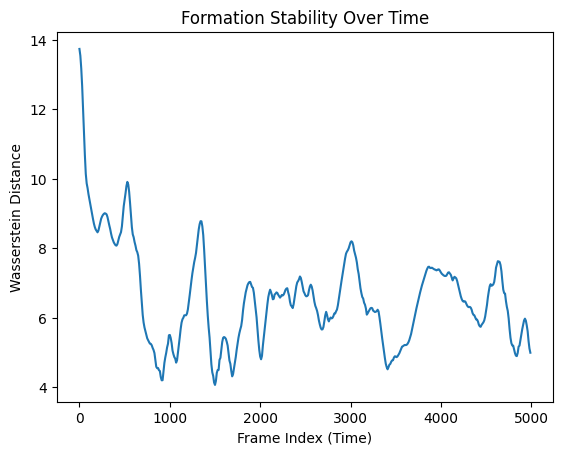

In [17]:
# Calculate distances between consecutive frames over a range of frames
frame_indices = list(range(0, 5000, 10))  # Example frames every 10 seconds
distances_over_time = [
    compute_team_wasserstein_distance(df, frame_idx=i) for i in frame_indices
]

# Plot the distances over time
import matplotlib.pyplot as plt

plt.plot(frame_indices, distances_over_time)
plt.xlabel('Frame Index (Time)')
plt.ylabel('Wasserstein Distance')
plt.title('Formation Stability Over Time')
plt.show()
